In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from itertools import product, cycle
from heapq import heapify, heappush, heappop
import cv2
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import networkx as nx

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.collections import PatchCollection
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase
from omnilearn import viz as viz_util

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from src import sample_full_interventions, response_mat, factor_reponses
from src.responses import sample_full_interventions

# import gpumap
from c3linearize import linearize, class_graph


In [2]:
device = 'cuda'
figure_root = Path('figures/responses')
figure_root = None
if figure_root is not None and not figure_root.exists():
    figure_root.mkdir()
seed = 10
B = 128
N = 16
G = 32

In [3]:
dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)
# dataset = fig.quick_run('load-data', name='full-mpi3d', labeled=True, shuffle=False, sort=True, seed=seed)
# images = dataset.images
# labels = dataset.labels
# images.shape, labels.shape
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: '3dshapes'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'full'
|  > mode-aliases: {} (by default)
|  > seed: 10
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 10
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/3dshapes)
|  >  > mode: 'full'
|  >  > labeled: True
|  >  > label_type: 'class' (by default)
|  >  > din: (3, 64, 64) (by default)
|  >  > dout: 6 (by default)
|  >  > device: 'cuda' (by default)
|  >  > fid_ident: None (by 

480000

In [4]:
batch = dataset.get_batch(shuffle=True)
X, Y = batch
X.shape, Y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 6]))

In [5]:
# util.plot_imgs(X);

In [6]:
factors = dataset.get_factor_order()
factor_sizes = dataset.get_factor_sizes()
factors, factor_sizes

(['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation'],
 [10, 10, 10, 8, 4, 15])

In [7]:
sampler = InterventionSamplerBase(dataset)
interventions = sample_full_interventions(sampler, num_groups=20, pbar=tqdm)

  0%|          | 0/6 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


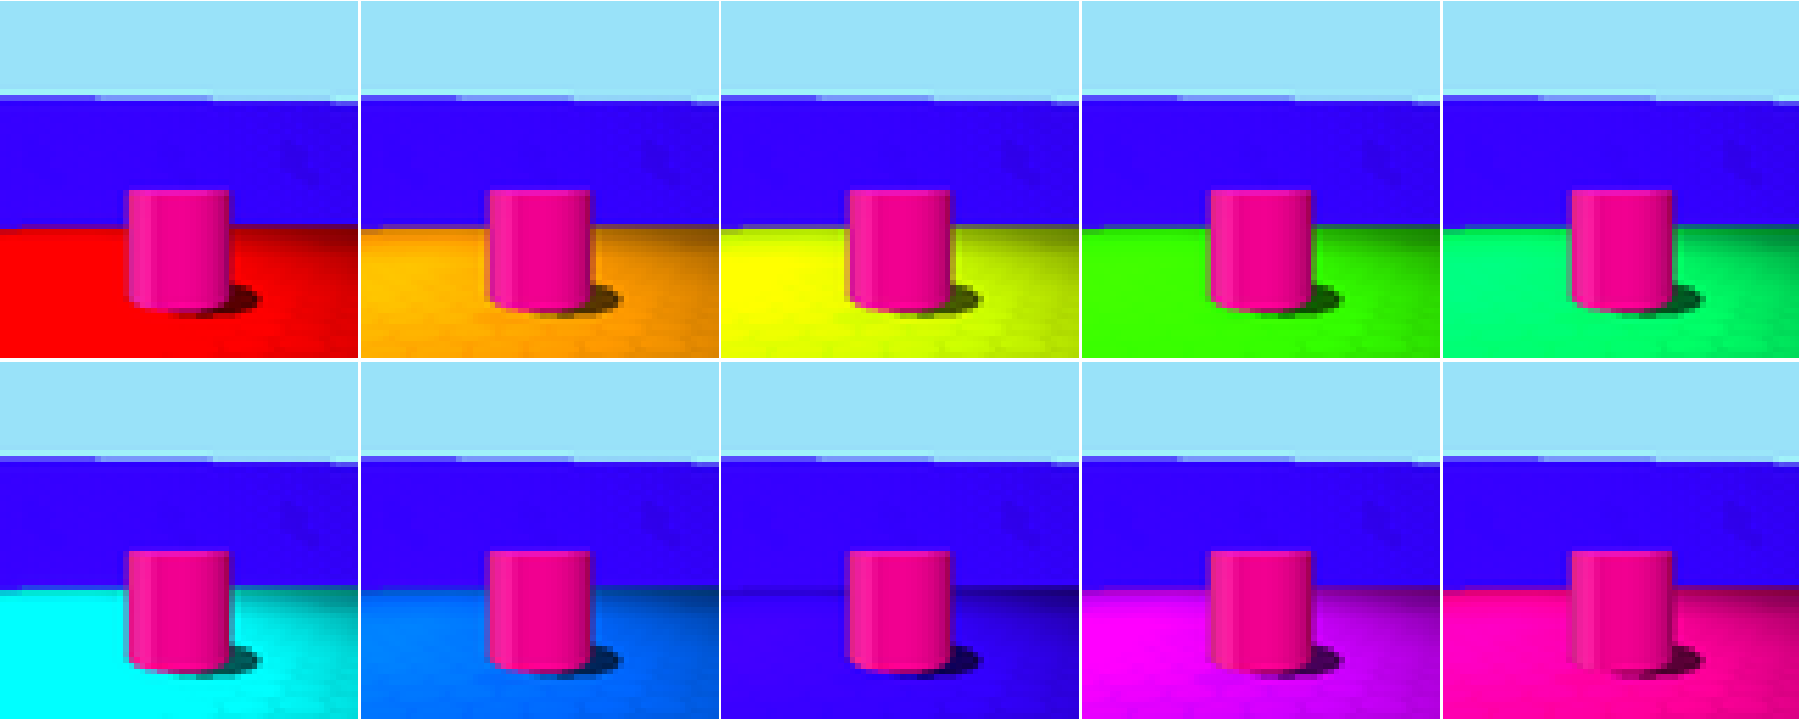

In [8]:
intervention_dim = 0
intervention_imgs = sampler.full_intervention(intervention_dim)
imgs = intervention_imgs
util.plot_imgs(imgs);

In [9]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
# root = Path(r'C:\Users\anwan\Documents\workspace\trained_nets')
# root = Path(r'C:/Users/anwan/Documents/workspace/exts/')
run_names = os.listdir(str(root))
len(run_names)

238

In [10]:
print(tabulate(enumerate(run_names)))

---  -------------------------------------------------
  0  3ds_ae0_e-c12_d-c12_210125-045343
  1  3ds_ae0_e-c12_d-c12_coord_210125-045521
  2  3ds_ae0_e-c12_d-c12_mish_210125-050038
  3  3ds_ae0_e-c12_d-c12_res-nn_210125-045937
  4  3ds_ae0_e-c12_d-c12_res_210125-045520
  5  3ds_ae0_e-c12_d-s12_210125-045438
  6  3ds_ae0_e-c12_d-s12_coord_210125-050236
  7  3ds_ae0_e-c12_d-s12_mish_210125-050335
  8  3ds_ae0_e-c12_d-s12_nosplit_210125-045438
  9  3ds_ae0_e-c12_d-s12_res-nn_210125-050336
 10  3ds_ae0_e-c12_d-s12_res_210125-050235
 11  3ds_ae0_e-c12_d-s2_210125-132645
 12  3ds_ae0_e-c12_d-s2_nosplit_210125-134343
 13  3ds_ae0_e-c12_d-s3_210125-134123
 14  3ds_ae0_e-c12_d-s3_nosplit_210125-134835
 15  3ds_ae0_e-c12_d-s4_210125-045438
 16  3ds_ae0_e-c12_d-s4_mish_210125-140253
 17  3ds_ae0_e-c12_d-s4_nosplit_210125-045440
 18  3ds_ae0_e-c12_d-s4_seed2_210125-133117
 19  3ds_ae0_e-c12_d-s6_210125-045438
 20  3ds_ae0_e-c12_d-s6_lrp0003_210125-171518
 21  3ds_ae0_e-c12_d-s6_lrp0004_210125-17

In [869]:
# run_name = run_names[7] # s12 mish
# run_name = run_names[5] # s12
# run_name = random.choice(run_names)
# run_name = run_names[0] # ae conv
# run_name = run_names[49]
run_name = run_names[57]
run_name = run_names[50]
run_name = run_names[48]

# run_name = run_names[32]

# run_name = '3ds_vae2_e-c12_d-c12_210125-045344'
# run_name = '3ds_vae1_e-l12_d-l12_210125-045439'
# run_name = '3ds_vae16_e-c12_d-c12_210125-045345'

# run_name = short[0]

run_name = '3ds_vae4_d-conv_b4-d24_210411-165936'
# run_name = '3ds_ae_e-c12_d-s12_tanh-seed10_210414-171333'
# run_name = '3ds_ae_e-c12_d-s12_seed3-mish_210126-004805'
# run_name = '3ds_ae_e-c12_d-s12_d24-lr0001_210414-171331'
run_name

'3ds_vae4_d-conv_b4-d24_210411-165936'

In [870]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'dataset_type': '3ds',
 'dec_type': 'conv',
 'extra': 'b4-d24',
 'model_type': 'vae',
 'size': 64}

In [871]:
if figure_root is not None:
    figure_dir = figure_root / run_name
    if not figure_dir.exists():
        figure_dir.mkdir()
else:
    figure_dir = None
model = run.get_model()
model.switch_to('val')
model.to(device);
def ae_cycle(q):
    im = model.decode(q.to(device))
    q = model.encode(im)
    if isinstance(q, distrib.Normal):
        q = q.loc
    return im.cpu(), q.cpu()
def encode(x):
    with torch.no_grad():
        q = model.encode(x.to(device))
        if isinstance(q, distrib.Normal):
            q = q.loc
    return q
def decode(q):
    with torch.no_grad():
        return model.decode(q.to(device))

Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNo

In [872]:
# ckptname = '1280'
# info = None
# if figure_root is not None:
#     figure_dir = figure_root / f'tf_model_{ckptname}'
#     if not figure_dir.exists():
#         figure_dir.mkdir()
# else:
#     figure_dir = None
# model = fig.quick_run('load-model', 'a/dislib', 'm/vae', device=device, **{'tf-ckpt-path': ckptname, 'model.nonlin': 'relu'})
# model

In [873]:
figure_dir

In [874]:
# dataset = run.get_dataset()
# dataset.switch_to('val')
# len(dataset)

In [875]:
# if R is None:
#     with torch.no_grad():
#         R, Q = model(X, ret_q=True)
#         if isinstance(Q, distrib.Distribution):
#             Q = Q.loc

In [876]:
# util.plot_imgs(X[:N])
# plt.suptitle('Original')
# plt.subplots_adjust(top=0.95)
# util.plot_imgs(R[:N])
# plt.suptitle('Reconstructions')
# plt.subplots_adjust(top=0.95)
# pass

In [877]:
stretch = 0.1

In [878]:
Qdis = None
with torch.no_grad():
    Q = model.encode(X.to(device))
    if isinstance(Q, distrib.Normal):
        Qdis = Q
        Q = Q.mean
    Q = Q.cpu()

rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg

In [879]:
bidx = 0

q = Q[bidx]
Q.shape, q.shape

(torch.Size([64, 24]), torch.Size([24]))

In [880]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
D = fullQ.size(-1)
fullQ.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 24])

In [881]:
scales = fullQ.std(0)
# scales = None

<IPython.core.display.Javascript object>


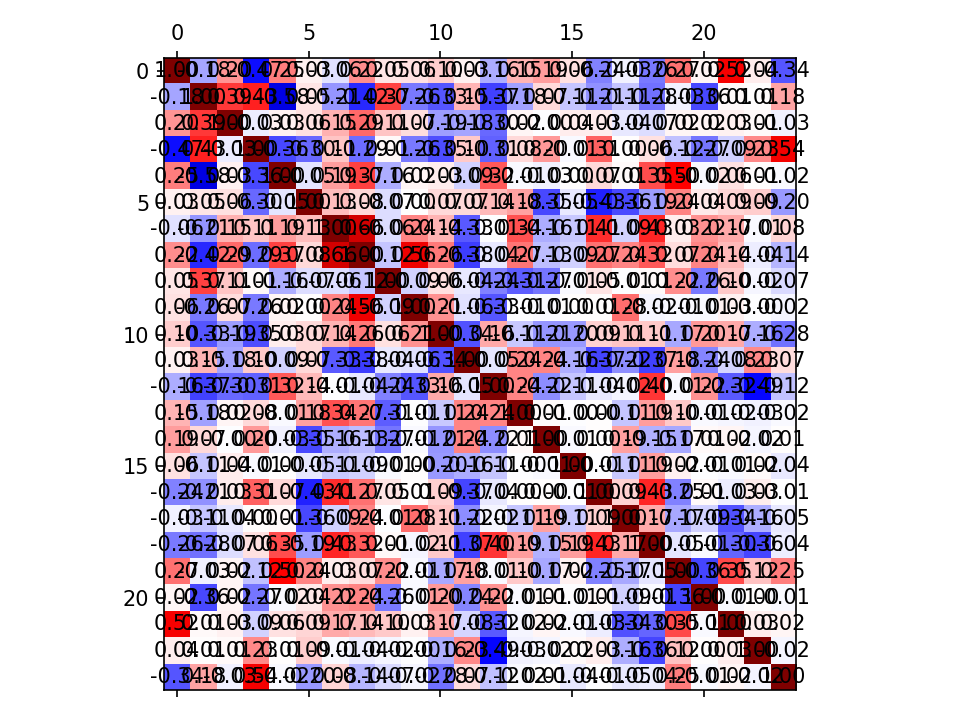

In [882]:
C = np.cov(fullQ.div(scales).cpu().t().numpy())
util.plot_mat(C, val_fmt=2, cmap='seismic', vmin=-1, vmax=1)
plt.tight_layout()
# util.save_figure(f'{run_name}_cov', root=figure_dir)
util.save_figure(f'cov', root=figure_dir)

In [1148]:
N = 100
R = response_mat(fullQ[:N], model.encode, model.decode, scales=scales, dist_type='rms', force_different=True)

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


In [885]:
# util.plot_mat(R, val_fmt=1) # responses
# plt.ylabel('Intervention')
# plt.xlabel('Response')
# plt.tight_layout()
# # util.save_figure(f'{run_name}_full_responses', root=figure_dir)
# util.save_figure(f'full_responses', root=figure_dir)

In [886]:
threshold = 0.5
threshold_2d = 0.1

In [1150]:
sel = torch.arange(len(R))[R.diag() > threshold]
bsel = torch.arange(len(R))[R.diag() <= threshold]
sel, bsel

(tensor([ 2,  4,  9, 13, 14, 15, 16, 20, 21, 22, 23]),
 tensor([ 0,  1,  3,  5,  6,  7,  8, 10, 11, 12, 17, 18, 19]))

In [888]:
# # epsilon interventions
# mags = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
# frames = []
# for mag in tqdm(mags):
#     Rm = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, mag=mag, dist_type='rms', force_different=True)
#     fg, _ = util.plot_mat(Rm, val_fmt=1) # responses
#     plt.ylabel('Intervention')
#     plt.xlabel('Response')
#     plt.tight_layout()
#     frame = util.fig_to_rgba(fg)
#     plt.close(fg)
#     frames.append(frame)
# frames = np.stack(frames)
# frames.shape

In [889]:
# mov = util.Video(frames)
# if figure_dir is not None:
#     path = figure_dir / f'seq{bidx}.mp4'
# #     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
#     mov.export(path)
#     print(f'Movie saved: {str(path)}')
# mov.play('jupyter', scale=1, fps=5)

In [890]:
# G = nx.from_numpy_matrix(R.cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

# colors = 'C1'
# colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

# edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(G)
# except:
# #     pos = nx.spring_layout(G)
#     pos = nx.circular_layout(G)

# kwargs = dict(pos=pos, node_color=colors, with_labels=True,
#               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(G, **kwargs)
# # util.save_figure(f'{run_name}_graph', root=figure_dir)
# util.save_figure(f'graph', root=figure_dir)

<IPython.core.display.Javascript object>


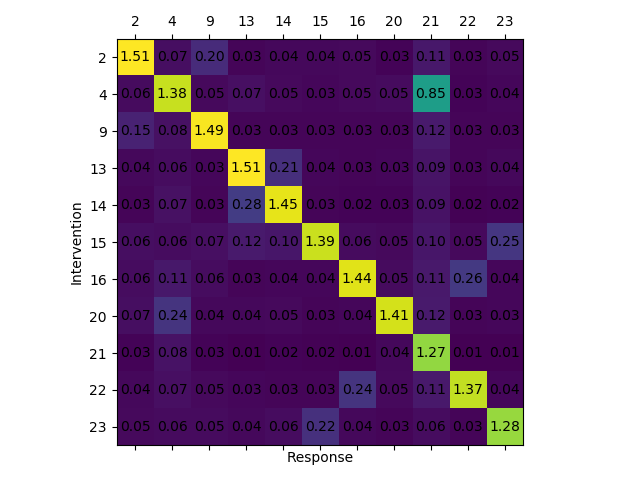

In [1151]:
util.plot_mat(R[sel][:,sel], val_fmt=2) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
# util.save_figure(f'sel_responses', root=figure_dir)

In [1258]:
# G = nx.from_numpy_matrix(R[sel][:,sel].cpu().pow(1.5).numpy(), create_using=nx.MultiDiGraph)

# colors = 'C2'
# # colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

# edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(G)
# except:
# #     pos = nx.spring_layout(G)
#     pos = nx.circular_layout(G)

# kwargs = dict(pos=pos, node_color=colors, labels={i:str(n.item()) for i,n in enumerate(sel)},#, with_labels=True,
#               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(G, **kwargs)
# # util.save_figure(f'{run_name}_graph', root=figure_dir)
# util.save_figure(f'sel-graph', root=figure_dir)

In [894]:
mats, lts = factor_reponses(model.encode, model.decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


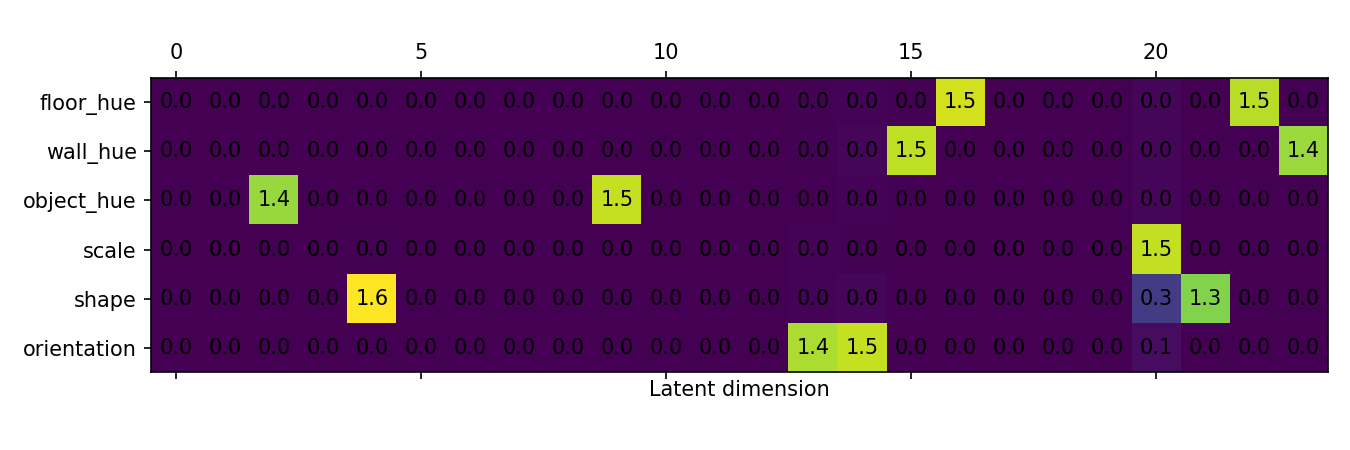

In [895]:
M_old = mats.min(1)[0].max(-1)[0]
M = mats.min(1)[0].diagonal(0,-1,-2)
M = mats.mean(1).diagonal(0,-1,-2)
# M = mats.max(1)[0].diagonal(0,-1,-2)
# M = mats.mean(1).max(-1)[0]

# mats.shape, len(lts), M.shape

util.plot_mat(M, val_fmt=1, figsize=(9,3))
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
util.save_figure(f'factor-responses', root=figure_dir);

In [896]:
resp = R#[sel][:,sel]
D = resp.size(-1)
resp.shape

torch.Size([24, 24])

In [897]:
unidir = {}
bidir = {}
imps = []
for i,j in zip(*torch.triu_indices(*resp.shape, 1).tolist()):
    if resp[i,i] > threshold and resp[j,j] > threshold:
        imp = resp[i,j].item() + resp[j,i].item()
        if resp[i,j] > threshold_2d and resp[j,i] > threshold_2d:
            bidir[i,j] = imp
        elif resp[i,j] > threshold or resp[j,i] > threshold:
            unidir[i,j] = imp
        imps.append(imp)
#         pairs[i,j] = imp
imps = torch.tensor(imps).float()
# pairs = {k:v for k,v in pairs.items() if v >= threshold}
# pairs, vitals = zip(*sorted(pairs.items(), key=lambda x:x[1], reverse=True))
# pairs, vitals
if len(unidir):
    unidir, univals = zip(*unidir.items())
if len(bidir):
    bidir, bivals = zip(*bidir.items())
list(unidir), list(bidir)

([(4, 21)], [(2, 9), (13, 14), (15, 23), (16, 22)])

In [898]:
def _gen_se2_inds(i,j):
    return [(i,i), (i,j), (i,D), (j,i), (j,j), (j,D)]

def gen_inds(*idx, dims=2):
    return list(product(*[idx]*dims))


In [899]:
# plt.figure(figsize=(9,2))
# plt.hist(imps, bins=100);

In [900]:
pt_num = 200

In [1288]:
dims = unidir[0]
dims = bidir[1]

# dims = (3,6)
# dims = 8,9

# dims = (4, 20)
# dims = [4, 5]
# dims = (20, 10)

ix, iy = dims
dims

(13, 14)

In [1289]:
Qsel = Q[:,dims]
pt = Qsel.sub(Qsel.mean(0,keepdim=True))
# plt.figure()
# plt.scatter(*pts.t(), marker='.', c='k');
U, S, V = torch.svd(pt.t() @ pt / (len(pt) - 1))
S = S.sqrt()
print('S',S)
print(U)
Q.shape, Qsel.shape

S tensor([0.6899, 0.6795])
tensor([[-0.6048,  0.7964],
        [ 0.7964,  0.6048]])


(torch.Size([64, 24]), torch.Size([64, 2]))

In [1290]:
vec = fullQ[N:N+pt_num].detach().cpu()
pts = vec[:,dims]
mu = pts.mean(0)
pt = pts.sub(pts.mean(0,keepdim=True))
U, S, V = torch.svd(pt.t() @ pt / (B - 1))
S = S.sqrt()
# plt.figure()
# plt.scatter(*pts.t(), marker='.', c='k');
# plt.axis('equal');
# plt.grid(b=True, which='both', color='0.65', linestyle='--')
# ars = torch.stack([mu, mu+S[0]*U[0]])
# plt.plot(*ars.t());
# ars = torch.stack([mu, mu+S[1]*U[1]])
# plt.plot(*ars.t());
se2 = util.aff_invert(util.se2_tfm(U, mu.unsqueeze(1)))
fixed = util.aff_transform(pts, se2)
# plt.scatter(*fixed.t(), marker='x', c='r');

In [1291]:
# skpts = Qsel.numpy()
skpts = pts.numpy()

bandwidth = estimate_bandwidth(skpts, quantile=0.1, )#n_samples=500)
bandwidth

0.3149500513420185

In [1292]:
quants = np.linspace(0,1,101)[1:-1]
quants = torch.logspace(0,1,20)[1:-1].sub(1).div(9).numpy()
bns = np.array([estimate_bandwidth(skpts, quantile=b, ) for b in quants])
bns = bns[bns>0]
slopes = bns[1:]-bns[:-1]
slopes_diffs = (slopes[:-1] + slopes[1:])/2
# plt.figure()
# plt.plot(quants,bns);
# plt.figure(figsize=(8,2))
# plt.plot(bns[1:-1], slopes_diffs);
bns

array([0.02316709, 0.06196112, 0.09794872, 0.19240086, 0.28225194, 0.35989045, 0.41966943, 0.50639637, 0.5940306 ,
       0.72967067, 0.92926804, 1.057071  , 1.14218665, 1.24021555, 1.39699509, 1.56121735, 1.67633759, 1.82467651])

In [1293]:
best_idx = slopes_diffs.argmax()
bandwidth = bns[1:][best_idx]
best_idx,bandwidth

(8, 0.7296706719849665)

In [1294]:
# bnsel = bns[1:31]
numcls = []
mss = []

for bandwidth in bns:
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    # ms = DBSCAN(eps=0.3, min_samples=2, metric='euclidean')
    ms.fit(skpts)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    numcls.append(len(labels_unique))
    mss.append(ms)
numcls = np.array(numcls)
options = np.unique(numcls)
options = options[options>1]
options = options[options<len(vec)//2]
mss = {o:mss[numcls.tolist().index(o)] for o in options}
# plt.figure()
# plt.plot(bnsel,numcls)
options

array([ 2,  3,  4,  5,  6,  7,  9, 14, 17, 31])

In [1295]:
op = options[0]
lbls = mss[op].labels_

In [1296]:
dists = {}
for op in options:
    lbls = mss[op].labels_
    ingroup, outgroup = skpts.copy(), skpts.copy()
    for c in range(op):
        sel = lbls == c
        i = np.arange(len(skpts))[sel]
        o = np.arange(len(skpts))[lbls != c]
        ingroup[i] = skpts[np.random.choice(i,size=len(i))]
        outgroup[i] = skpts[np.random.choice(o,size=len(i))]
    
    invec = vec.clone()
    invec[...,dims] = torch.from_numpy(ingroup)
    outvec = vec.clone()
    outvec[...,dims] = torch.from_numpy(outgroup)
    with torch.no_grad():
        rvec = ae_cycle(vec)[1]
        invec = ae_cycle(invec)[1]
        outvec = ae_cycle(outvec)[1]
    
    inD = rvec[...,dims].sub(invec[...,dims]).pow(2).mean(-1)
    outD = rvec[...,dims].sub(outvec[...,dims]).pow(2).mean(-1)
    
    dists[op] = inD, outD
correct = None
cscore = None
scores = []
for op in options:
    i,o = dists[op]
    i, o = i.max().item(), o.min().item()
    if correct is None and i<o:
        correct = op
        cscore = o-i
    scores.append(o-i)
best = options[np.argmax(scores)]
#     print(f'{op}: {i<o} {i} < {o}')
catm = None if correct is None else mss[correct]
ms = None
ms = mss[best]
cluster_centers = ms.cluster_centers_
labels = ms.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
print(f"number of clusters in best : {n_clusters_} (score: {max(scores)})")
if catm is not None:
    print(f"number of clusters in correct : {max(catm.labels_)+1} (score: {cscore})")
# print('Found a cluster mapping' if catm is not None else 'Did not find a mapping')

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


number of clusters in best : 14 (score: -0.0014563649892807007)


In [1297]:
# plt.figure()
# plt.plot(options,scores);

In [1298]:
stretch = .2
rg = 2

mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
mn, mx = mn.view(-1), mx.view(-1)

print(mn[list(dims)], mx[list(dims)])

mn, mx = torch.ones(len(mn))*-rg, torch.ones(len(mx))*rg

tensor([-1.4006, -1.3003]) tensor([1.3651, 1.6882])


In [1299]:
n = 100
h, w = n, n

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = Q[bidx:bidx+1].expand(len(cx), -1).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy
vecs.shape

torch.Size([10000, 24])

In [1300]:
starts = vecs[...,dims]
ends = []
for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=100), desc=f'Cycling {len(vecs)} samples'):
    with torch.no_grad():
        ends.append(ae_cycle(v)[1][...,dims])
starts = starts.view(h,w,2)
ends = torch.cat(ends).view(h,w,2)
dels = ends.sub(starts)
delmap = dels.permute(1,0,2).numpy()[::-1]
ends.shape

Cycling 10000 samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([100, 100, 2])

In [1301]:
cts = torch.from_numpy(cluster_centers)
xinds = torch.searchsorted(xvals, cts[:,0].contiguous())
yinds = torch.searchsorted(yvals, cts[:,1].contiguous())
cinds = torch.stack([xinds,yinds],-1)
cinds = [tuple(c) for c in cinds.tolist()]
cinds

[(49, 36),
 (29, 57),
 (72, 45),
 (27, 48),
 (71, 54),
 (41, 31),
 (67, 30),
 (67, 70),
 (63, 79),
 (69, 61),
 (32, 75),
 (56, 33),
 (30, 65),
 (31, 33)]

In [1302]:
dels.shape

torch.Size([100, 100, 2])

In [1303]:
# dmap = torch.cdist(starts, Qsel).min(-1)[0].view(n,n)
dmap = torch.cdist(starts, cts).min(-1)[0].view(n,n)
# dmap = torch.cdist(starts, Qsel).mean(-1).view(n,n)
distmap = dmap.numpy()
dmap = dmap.t().numpy()[::-1]

mags = dels.pow(2).sum(-1)
costmap = mags.numpy()
mags = mags.t().numpy()[::-1]
# mags = deltas.view(h,w,2)[...,0]

normdels = dels.div(dels.norm(dim=-1,keepdim=True))
def get_divergence(deltas):
    divx, divy = np.gradient(deltas, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)
divM = get_divergence(dels)
ndivM = get_divergence(normdels)

happymap = divM<0
happy = happymap.t().numpy()[::-1]
# landscape = divM - divM.min()
# divM -= divM.min()
divergence = divM
divM = divM.t().numpy()[::-1]
posterior_logits = ndivM.mul(-1)
ndivM = posterior_logits.t().numpy()[::-1]

divMprop = torch.from_numpy(divM.copy()).clone()
divMprop[divMprop>0] /= divMprop[divMprop>0].max().abs()
divMprop[divMprop<0] /= divMprop[divMprop<0].min().abs()
divMprop = divMprop.numpy()

ndivMprop = torch.from_numpy(ndivM.copy()).clone()
ndivMprop[divMprop>0] /= ndivMprop[divMprop>0].max().abs()
ndivMprop[divMprop<0] /= ndivMprop[divMprop<0].min().abs()
ndivMprop = ndivMprop.numpy()


fmag = mags + dmap
spacemap = distmap + costmap

fmag = mags
spacemap = costmap

In [1306]:
def cdf(x):
    return x.div(np.sqrt(2)).erf().add(1).div(2)
dx = xvals[1]-xvals[0]
xedges = torch.linspace(xvals[0]-dx/2,xvals[-1]+dx/2,w+1)
dy = yvals[1]-yvals[0]
yedges = torch.linspace(yvals[0]-dy/2,yvals[-1]+dy/2,h+1)
xcdf = cdf(xedges)
xprob = xcdf[1:] - xcdf[:-1]
ycdf = cdf(yedges)
yprob = ycdf[1:] - ycdf[:-1]
xyprob = torch.stack(torch.meshgrid(xprob, yprob)).prod(0)
xyprob.sum(), xyprob[~happymap].sum(), xyprob[~happymap].sum().div(xyprob.sum())

(tensor(0.9152), tensor(0.1481), tensor(0.1619))

<IPython.core.display.Javascript object>


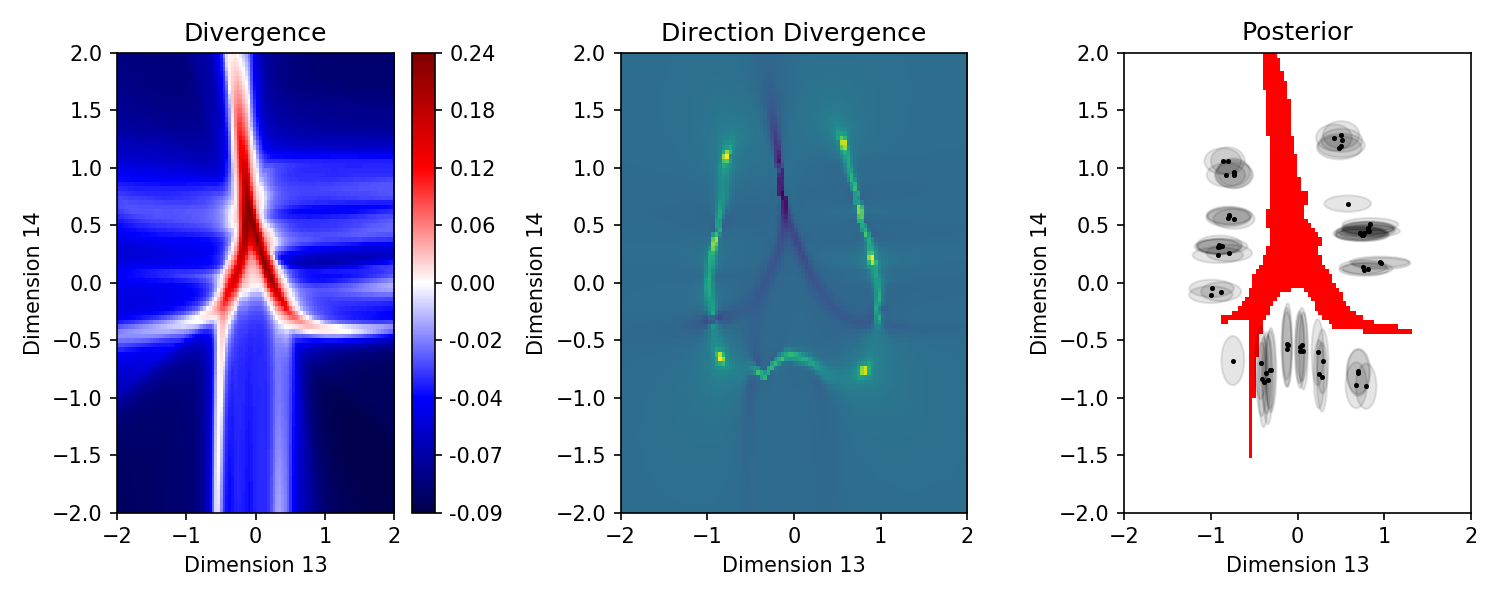

In [1307]:
im = fmag
im = divM
# im = happy

# plt.figure()
# # plt.title('Map')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(im, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
# plt.tight_layout()

aspect_ratio = 'auto'
# aspect_ratio = 1

fg, axs = plt.subplots(1,3, figsize=(10,4))
plt.sca(axs[0])
# plt.title('Distance Mags')
# plt.imshow(dmap, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
plt.title('Divergence')
plt.imshow(divMprop, cmap='seismic', extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divM.min(), 0,5), np.linspace(0,divM.max(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)
# cbar.set_ticks(np.linspace(-1, 1,9), np.linspace(divM.min(), divM.max(),9))
# plt.imshow(divM);
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')

plt.sca(axs[1])
plt.title('Direction Divergence')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(ndivMprop, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.imshow(ndivM);

plt.sca(axs[2])
plt.title('Posterior')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
# plt.imshow(mags, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
badsel = np.ones((*happy.shape,4))
badsel[...,-1] = 0.
badsel[~happy] = [1,0,0,1]
plt.imshow(badsel, #np.stack([happy, np.ones_like(happy), np.ones_like(happy), ], -1)*255,
#            cmap='Reds', alpha=0.8, 
           extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(mags);
plt.tight_layout()


In [1308]:
locs = Qdis.loc[...,dims].cpu()
widths = Qdis.scale[...,dims].cpu()*3
Qlbls = ms.predict(locs.numpy())
for c, s, l in zip(locs, widths, Qlbls):
    e = mpatches.Ellipse(c, *s, alpha=0.1, color='k')#color=colors[l])
    plt.gca().add_artist(e)
plt.scatter(*locs.t(), marker='o', color='k', s=2)

In [1309]:
# plt.figure()

# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(xyprob,
#            extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)
# plt.imshow(badsel, alpha=0.5,
#            extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio)

In [1310]:
temps = torch.logspace(-2,1,50)
temps = torch.linspace(0.01,10,100)
probs = torch.stack([F.softmax(temp*posterior_logits.view(-1),dim=-1) @ xyprob.view(-1) for temp in temps])
# plt.figure()
# plt.plot(temps,probs);
best_temp = temps[probs.max(0)[1]]
best_temp.item()

10.0

In [1281]:
# fg, axs = plt.subplots(1,2, figsize=(9,5))
# plt.sca(axs[0])
# plt.title('X component')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(delmap[...,0], extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);

# plt.sca(axs[1])
# plt.title('Y component')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(delmap[...,1], extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
# plt.tight_layout();

In [1282]:
# divy = (dels[1:,:,1] - dels[:-1,:,1])
# divx = (dels[:,1:,0] - dels[:,:-1,0])

# divM = divM.pow(2).sum(-1)
# plt.figure()
# plt.title('Divergence')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(divM, )#extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);
# plt.tight_layout()

<IPython.core.display.Javascript object>


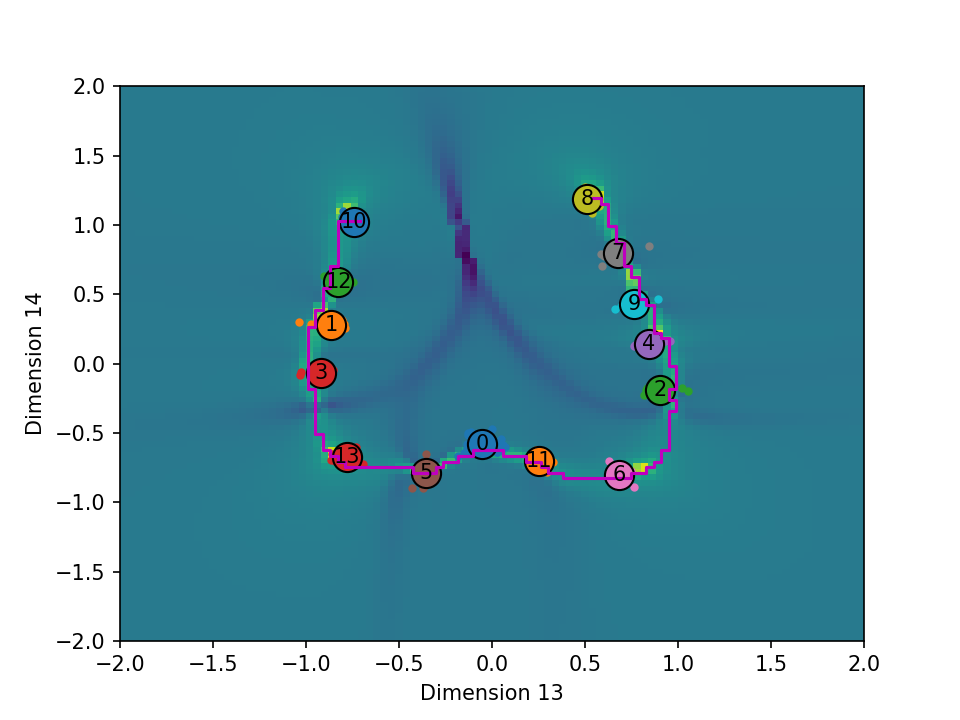

0.1

In [1311]:
temp = best_temp
temp = 1
temp = 0.1



posterior = F.softmax(posterior_logits.div(temp).view(-1),dim=-1).view(*posterior_logits.shape)
landscape = F.softmax(posterior_logits.div(-temp).view(-1),dim=-1).view(*posterior_logits.shape)
# landscape = F.softmax(divergence.div(temp).view(-1),dim=-1).view(*posterior_logits.shape)
posteriormap = posterior.t().numpy()[::-1]
landscapemap = landscape.t().numpy()[::-1]
# plt.figure()
# plt.imshow(posterior, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
plt.figure()
plt.imshow(ndivM, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()], aspect=aspect_ratio);
temp

In [1312]:
# plt.figure()
# plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
colors = [f'C{i}' for i in range(10)]*10
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(skpts[my_members, 0], skpts[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    plt.text(cluster_center[0], cluster_center[1], str(k), ha='center', va='center')
plt.xlabel(f'Dimension {ix}');
plt.ylabel(f'Dimension {iy}');

In [1313]:
DMAP = nx.grid_2d_graph(*mags.shape)
def _find_route(u,v):
    L, ph = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(DMAP, cinds[u], cinds[v], weight=lambda u,v,_o: landscape[v])
    return L, (u,v), ph

In [1314]:
paths = [[None]*len(cinds) for _ in range(len(cinds))]
LD = torch.zeros(len(cinds), len(cinds))
CD = torch.zeros(len(cinds), len(cinds))
for i in tqdm(range(len(cinds))):
    for j in range(i+1,len(cinds)):
        L, (u,v), ph = _find_route(i,j)
        paths[i][j] = ph
        paths[j][i] = ph
        CD[i,j] = L
        CD[j,i] = L
        LD[i,j] = len(ph)
        LD[j,i] = len(ph)

  0%|          | 0/14 [00:00<?, ?it/s]

In [1315]:
longest = None
for i, ps in enumerate(paths):
    for j, p in enumerate(ps):
        if p is not None and (longest is None or len(longest) < len(p)):
            longest = p
            s,e = i,j
print(len(longest), s,e)

mypath = longest
# mypath = paths[10][8]
print(f'Path length: {len(mypath)}')

xlp, ylp = zip(*mypath)
xlp, ylp = xvals[list(xlp)], yvals[list(ylp)]
plt.plot(xlp, ylp, c='m');

174 8 10
Path length: 174


In [1337]:
ninterp = 7

bidx = 4

xvp, yvp = torch.linspace(xlp[0],xlp[-1],ninterp), torch.linspace(ylp[0],ylp[-1],ninterp)
vecs = Q[bidx:bidx+1].expand(len(xvp), -1).contiguous()
vecs[...,dims[0]] = xvp
vecs[...,dims[1]] = yvp

binterp = decode(vecs)

xpin, ypin = torch.linspace(0,len(xlp)-1,ninterp).long(), torch.linspace(0,len(ylp)-1,ninterp).long()
xvp, yvp = xlp[xpin], ylp[ypin]
vecs = Q[bidx:bidx+1].expand(len(xvp), -1).contiguous()
vecs[...,dims[0]] = xvp
vecs[...,dims[1]] = yvp

interp = decode(vecs)
interp.shape

torch.Size([7, 3, 64, 64])

<IPython.core.display.Javascript object>


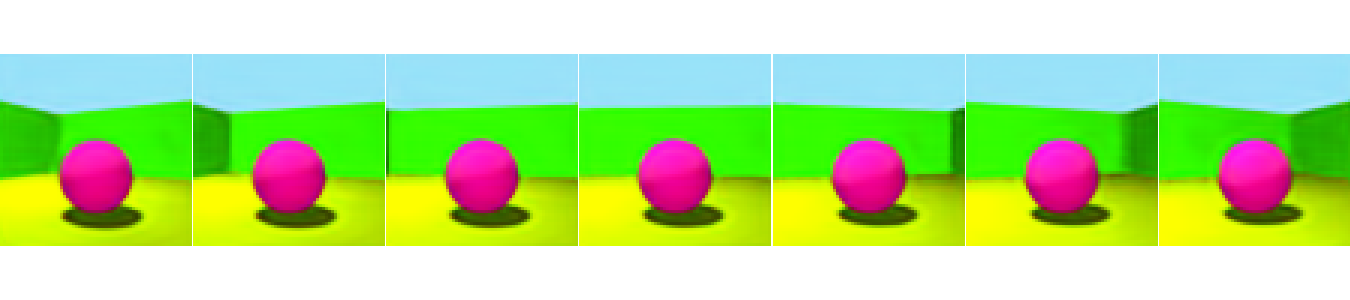

<IPython.core.display.Javascript object>


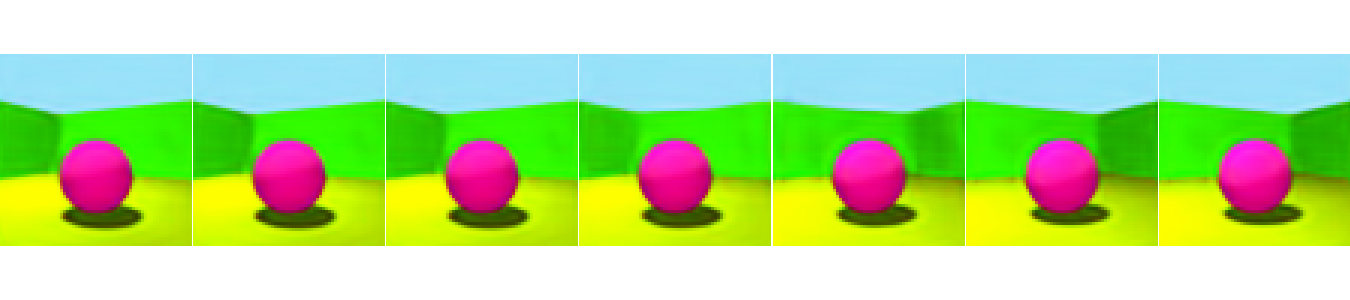

In [1338]:
util.plot_imgs(interp,W=len(interp), figsize=(9,2));
util.plot_imgs(binterp,W=len(binterp), figsize=(9,2));

In [936]:
# connect cluster nodes to model manifold as a sequence or ring -> skip for now

# inds = torch.triu_indices(*CD.shape,offset=1)
# vals = CD[tuple(inds)]
# order = inds.t()[vals.sort(0)[1]]
# inds.shape, vals.shape, order.shape

# order.tolist()

# G = nx.Graph()
# G.add_nodes_from(range(len(CD)))
# for s,e in order.tolist():
#     if len(G[s]) < 2 and len(G[e]) < 2 and e not in nx.algorithms.descendants(G,s):
#         G.add_edge(s,e, cost=CD[s,e].item())
# edges,costs = zip(*sorted(nx.get_edge_attributes(G,'cost').items(), key=lambda x: x[-1], reverse=False))
# # if costs[-1] > costs[-2]*2:
# #     G.remove_edge(edges[-1])
# ends = tuple(i for i in G.nodes if len(G[i])<2)
# last = CD[ends].item()
# seq = nx.shortest_path(G,*ends)
# if last < costs[-1]*2:
#     seq.append(ends[0])
#     G.add_edge(*ends, cost=last)
# plt.plot(*cts[seq].t(), c='r', ls='--', zorder=1);
# [last, costs, edges]

(torch.Size([2, 136]), torch.Size([136]), torch.Size([136, 2]))

In [863]:
def _project_dims(vecs):
    plt.figure()
    plt.scatter(*vecs[:,dims].detach().cpu().t(), marker='.', c='k');
    plt.axis('equal');
    plt.grid(b=True, which='both', color='0.65', linestyle='--')
    ix, iy = dims
    plt.xlabel(f'Dimension {ix}')
    plt.ylabel(f'Dimension {iy}')

In [85]:
# ind = dims

# fixed = util.aff_transform(Q, T)
# _project_dims(fixed)
# _project_dims(Q)

In [86]:
# bq = Q[:,dims]
# angs = torch.atan2(bq[:,0], bq[:,1])
# plt.figure(figsize=(9,2))
# count, hist, *other = plt.hist(angs, bins=100)
# plt.tight_layout();
# spec = torch.from_numpy(hist).rfft(1).norm(dim=-1)
# plt.figure()
# plt.plot(spec);

In [87]:
# nX = X.clone().unsqueeze(0).expand(nsamples,-1,-1, -1, -1).contiguous()
# nX += torch.rand_like(nX).mul(immag).clamp(min=0,max=1)
# nX = nX.reshape(-1,*X.shape[1:])
# rQ = encode(nX).cpu()#.view(nsamples, -1, D)
# plt.scatter(*util.aff_transform(rQ, T)[:,dims].t(), marker='x', s=15, linewidths=0.2, c='b', alpha=0.5);
# rQ = rQ.view(nsamples, -1, D)
# rQ.shape

In [89]:
# T = torch.eye(D+1,D+1)[:-1]

In [90]:
# rel_wts = []
# for ind in chain(unidir,bidir):
#     pts = vec[:,ind]
#     mu = pts.mean(0)
    
#     pt = pts.sub(pts.mean(0,keepdim=True))
#     U, S, V = torch.svd(pt.t() @ pt / (B - 1))
#     S = S.sqrt()
#     rel_wts.append(S)
    
#     se2 = util.aff_invert(util.se2_tfm(U, mu.unsqueeze(1)))
    
#     ref = torch.tensor(_gen_se2_inds(*ind))
    
#     t1 = torch.eye(D+1,D+1)[:-1]
#     t1[tuple(ref.t())] = se2.view(-1)
    
#     T = util.aff_compose(t1, T)
# Tinv = util.aff_invert(T)
# Tvec = T.clone()
# Tvec[...,0].zero_();

In [92]:
# nsamples = 4
# immag = 0.1
# nmag = 0.1
# nmag = None
# ups = [1, 2, 4, 8, 16, 32, 64]

In [93]:
# _nmag = 1/len(Q) if nmag is None else nmag
# nQs = []
# nQbase = Q.clone().unsqueeze(0).expand(nsamples,-1,-1).contiguous()
# nQ0 = ae_cycle(Q)[1].detach()
# for up in ups:
#     nQ = nQbase.clone()
#     nQ[...,dims] += torch.randn(nsamples, len(Q), 2).mul(S.view(1,1,2)) * _nmag * up
#     nQ = nQ
#     nQs.append(ae_cycle(nQ.reshape(-1,D))[1].detach().view(nsamples,-1,D))
# nQs = torch.stack(nQs)
# nQs.shape, nQ0.shape

In [94]:
# i = 4
# dQs = nQs.sub(nQ0)
# start = util.aff_transform(nQs[i], T)
# delta = util.aff_transform(dQs[i], Tvec)
# plt.scatter(*start[...,dims].t(), s=12, marker='x', c='g', alpha=0.5)
# plt.scatter(*start.add(delta)[...,dims].t(), marker='o', s=12, c='y', alpha=0.5)
# plt.quiver(*start[...,dims].t(), *delta[...,dims].t(), angles='xy', scale_units='xy', scale=1, lw=0.2, alpha=0.3);

In [95]:
# nQ = nQ.reshape(-1,D)

# plt.scatter(*util.aff_transform(start.reshape(-1,D), T)[:,dims].t(), marker='x', s=15, linewidths=0.2, c='r', alpha=0.5);

In [96]:
# errs = nQs[...,dims].sub(nQ0[...,dims]).norm(dim=-1).reshape(nQs.shape[0],-1)
# plt.figure()
# plt.plot(errs);

In [97]:
# gen_inds(*ind)

In [98]:
# _nmag = 1/len(Q) if nmag is None else nmag
# noise = torch.randn(nsamples, len(Q), 2).mul(S.view(1,1,2)) * _nmag * 8
# noise.shape

In [99]:
# nQ = Q.clone().unsqueeze(0).expand(nsamples,-1,-1).contiguous()
# nQ[...,dims] += noise
# nQ = nQ.reshape(-1,D)

# plt.scatter(*util.aff_transform(nQ, T)[:,dims].t(), marker='x', s=15, linewidths=0.2, c='r', alpha=0.5);

In [100]:
# nQ2 = ae_cycle(nQ)[1].detach()

# plt.scatter(*util.aff_transform(nQ2, T)[:,dims].t(), marker='x', s=15, linewidths=0.2, c='b', alpha=0.5);

In [101]:
# dQ = nQ2.sub(nQ).abs()
# dQ.shape

In [102]:
# pdist = dQ[...,dims].norm(dim=-1)
# odist = dQ.norm(dim=-1).sub(pdist)

In [976]:
# # G = nx.from_numpy_matrix(R.cpu().pow(2).numpy(), create_using=nx.MultiDiGraph)

# colors = 'C1'
# # colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

# # edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(G)
# except:
# #     pos = nx.spring_layout(G)
#     pos = nx.circular_layout(G)

# kwargs = dict(pos=pos, node_color=colors, with_labels=True,
# #               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(G, **kwargs)
# # util.save_figure(f'{run_name}_graph', root=figure_dir)
# # util.save_figure(f'graph', root=figure_dir)

In [926]:
# L, ph = nx.algorithms.shortest_paths.weighted.multi_source_dijkstra(G, cinds[1:], cinds[0], weight=lambda u,v,_o: mags[v])

In [930]:
# plt.figure()
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(fmag, extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()]);

In [931]:
# LD = torch.zeros(len(cinds), len(cinds))
# for i, ps in enumerate(paths):
#     for j, p in enumerate(ps):
#         if p is not None:
#             LD[i,j] = len(p)
#             LD[j,i] = len(p)

In [965]:
# util.plot_mat(CD,val_fmt=1, figsize=(6,6));

In [933]:
# util.plot_mat(LD, val_fmt=0, figsize=(6,6));

In [934]:
# util.plot_mat(CD*LD, val_fmt=1, figsize=(6,6));

In [935]:
# GN = nx.from_numpy_matrix((CD*LD).cpu().numpy(), create_using=nx.Graph)

# colors = 'C1'
# # colors = ['C2' if i in sel else 'C3' for i in range(len(GN))]

# edges,weights = zip(*sorted(nx.get_edge_attributes(GN,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(GN)
# except:
# #     pos = nx.spring_layout(GN)
#     pos = nx.circular_layout(GN)

# kwargs = dict(pos=pos, node_color=colors, with_labels=True,
#               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(GN, **kwargs);
# # util.save_figure(f'graph', root=figure_dir)

In [1140]:
# plt.figure()
# mxd = CD.max().item()
# for i, ps in enumerate(paths):
#     for j, p in enumerate(ps):
#         if p is not None:
#             plt.plot(*zip(*p), c='C1', alpha=CD[i,j].item()/mxd)
# plt.scatter(*zip(*cinds),zorder=3, c='C3')
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(fmag[::-1]);
# plt.xlim(0,100);
# plt.ylim(0,100);

In [795]:
torch.triu_indices?

(torch.Size([2, 45]), torch.Size([45]), torch.Size([45, 2]))

In [38]:
# ref = torch.tensor(_gen_inds(*ind))

# # t1 = torch.cat([torch.eye(D,D), torch.zeros(D,1)],1)
# t1 = torch.eye(D+1,D+1)[:-1]

# t1[tuple(ref.t())] = se2.view(-1)
# # util.plot_mat(t1, val_fmt=2);

In [39]:
# T = util.aff_compose(t1, T)
# util.plot_mat(T, val_fmt=2);

In [72]:
def _encode(x):
    q = model.encode(x)
    if isinstance(q, distrib.Normal):
        q = q.loc
    return util.aff_transform(q, T.to(q.device))

def _decode(q):
    q = util.aff_transform(q, util.aff_invert(T.to(q.device)))
    return model.decode(q)

In [73]:
fQ = util.aff_transform(fullQ[:N], T.to(q.device))

Rstar = response_mat(fQ, _encode, _decode, scales=scales, dist_type='rms', force_different=True)

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


In [74]:
# util.plot_mat(Rstar, val_fmt=2) # responses
# plt.ylabel('Intervention')
# plt.xlabel('Response')
# plt.tight_layout()
# util.save_figure(f'fixed_responses', root=figure_dir)

In [75]:
ssel = torch.arange(len(R))[Rstar.diag() > threshold]
sbsel = torch.arange(len(R))[Rstar.diag() <= threshold]
ssel, sbsel

(tensor([ 2,  4,  9, 13, 14, 15, 16, 20, 21, 22, 23]),
 tensor([ 0,  1,  3,  5,  6,  7,  8, 10, 11, 12, 17, 18, 19]))

<IPython.core.display.Javascript object>


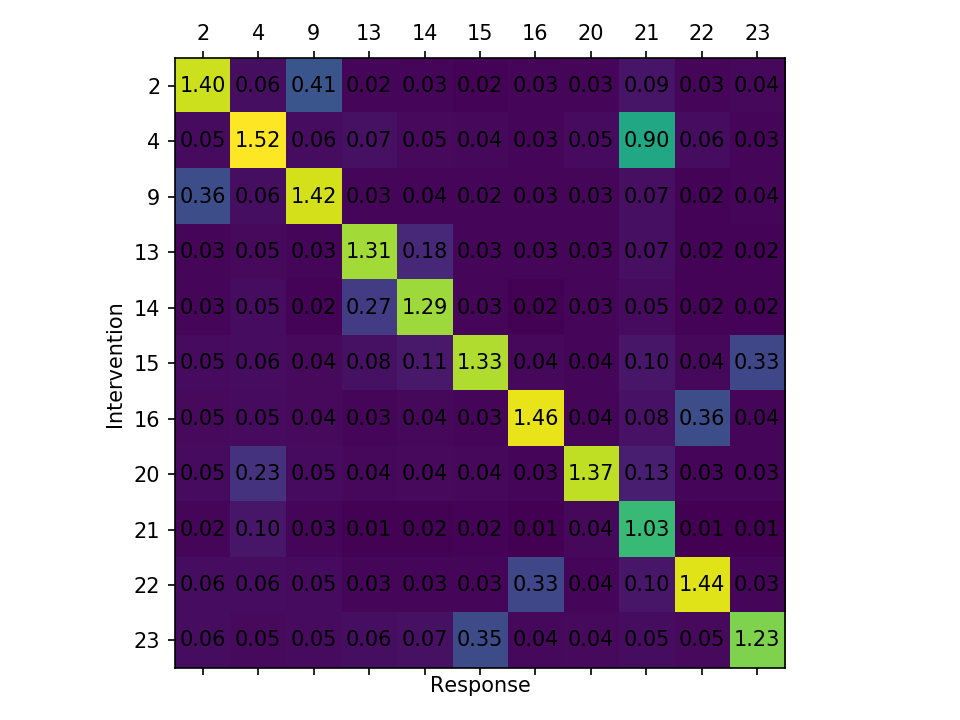

In [76]:
util.plot_mat(Rstar[ssel][:,ssel], val_fmt=2) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(ssel)), map(str,ssel.tolist()))
plt.yticks(np.arange(len(ssel)), map(str,ssel.tolist()))
plt.tight_layout()
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
util.save_figure(f'fixed_sel_responses', root=figure_dir)

In [340]:
# util.plot_mat(M_old, val_fmt=2)
# plt.yticks(range(len(factors)), factors)
# plt.xlabel('Latent dimension')
# plt.tight_layout()
# # util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
# util.save_figure(f'old-factor-responses', root=figure_dir)
# pass # an intervention on which latent dimension responds the most given that the intervention can 
# #      only change the given factor of variation

In [708]:
# matstar, ltstar = factor_reponses(_encode, _decode, interventions, pbar=tqdm, include_q=True, 
#                        resp_kwargs=dict(scales=scales,force_different=True))
# Mstar = matstar.min(1)[0].diagonal(0,-1,-2)
# util.plot_mat(Mstar, val_fmt=1)
# plt.yticks(range(len(factors)), factors)
# plt.xlabel('Latent dimension')
# plt.tight_layout()
# util.save_figure(f'fixed_factor_responses', root=figure_dir);

In [130]:
# full = interventions[3][1]
# with torch.no_grad():
#     fq = model.encode(full.to(device))
#     if isinstance(fq, distrib.Normal):
#         fq = fq.mean

In [131]:
# with torch.no_grad():
#     hq = model.hybridize(fq)
#     vim = model.decode(hq.to(device))
# util.plot_imgs(full);
# util.plot_imgs(vim);

In [714]:
n = 16
steps = 40
# info.steps = 20
# info.steps = 7
# info.steps = 5
ntrav = 1

In [727]:
q = Q[bidx]

tH, tW = 4,3
if info is None:
    tH, tW = 5, 2
else:
    if info['dec_type'] == 's6':
        tH, tW = 6,2
    if info['dec_type'] == 's3':
        tH, tW = 3,4

vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
      mnmx=(mn,mx)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape
    
if walks.size(1) != tH*tW:
    tH, tW = util.calc_tiling(walks.size(1))
    
tH, tW

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


(4, 3)

In [728]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
# print(full.shape)
full = full.squeeze(0).permute(2,0,4,1,5,3).contiguous()
frames = full.view(S, tH*H, tW*W, C).mul(255).byte().numpy()



frames.shape
# full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

(40, 256, 192, 3)

In [729]:

font                   = cv2.FONT_HERSHEY_SIMPLEX
font                   = cv2.FONT_HERSHEY_COMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 1

px, py = 2, 12

for frame in frames:
    for i,j in np.ndindex(tH, tW):
        idx = i*tW+j
        cv2.putText(frame, f'{idx}', 
            (px+H*j, py+W*i), 
            font, 
            fontScale,
            fontColor,
            lineType)


<IPython.core.display.Javascript object>


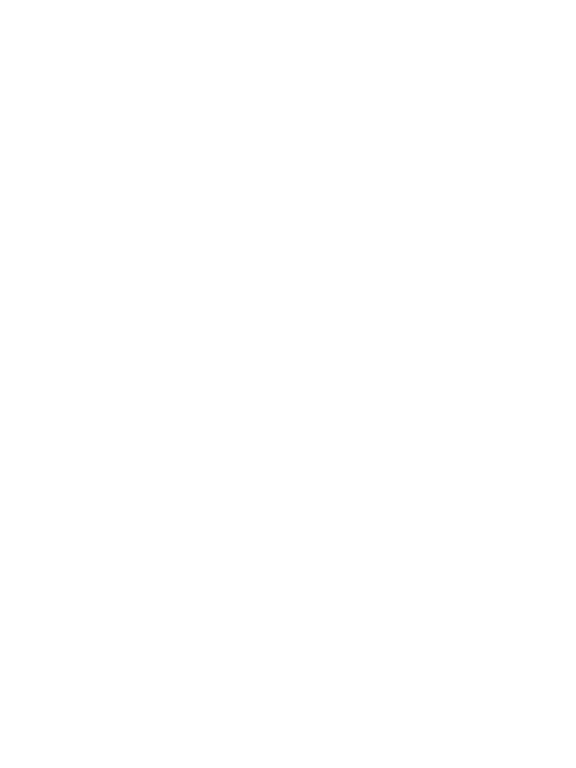

In [730]:
mov = util.Video(frames)
if figure_dir is not None:
    path = figure_dir / f'seq{bidx}.mp4'
#     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
    mov.export(path)
    print(f'Movie saved: {str(path)}')
mov.play('jupyter', scale=2)

<IPython.core.display.Javascript object>


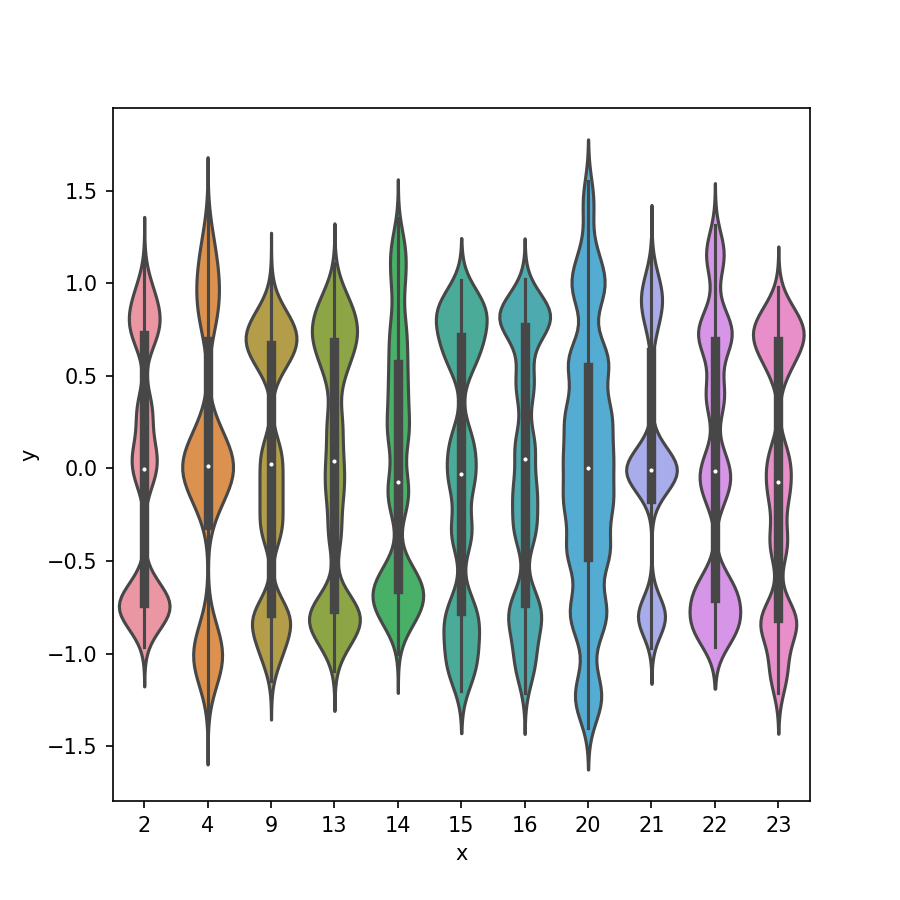

Figure latent_marginals saved as {'png'}


In [305]:
util.plot_distribs(fullQ.t()[sel].cpu());
plt.xticks(np.arange(len(sel)),sel.tolist());
util.save_figure(f'latent_marginals', root=figure_dir);

<IPython.core.display.Javascript object>


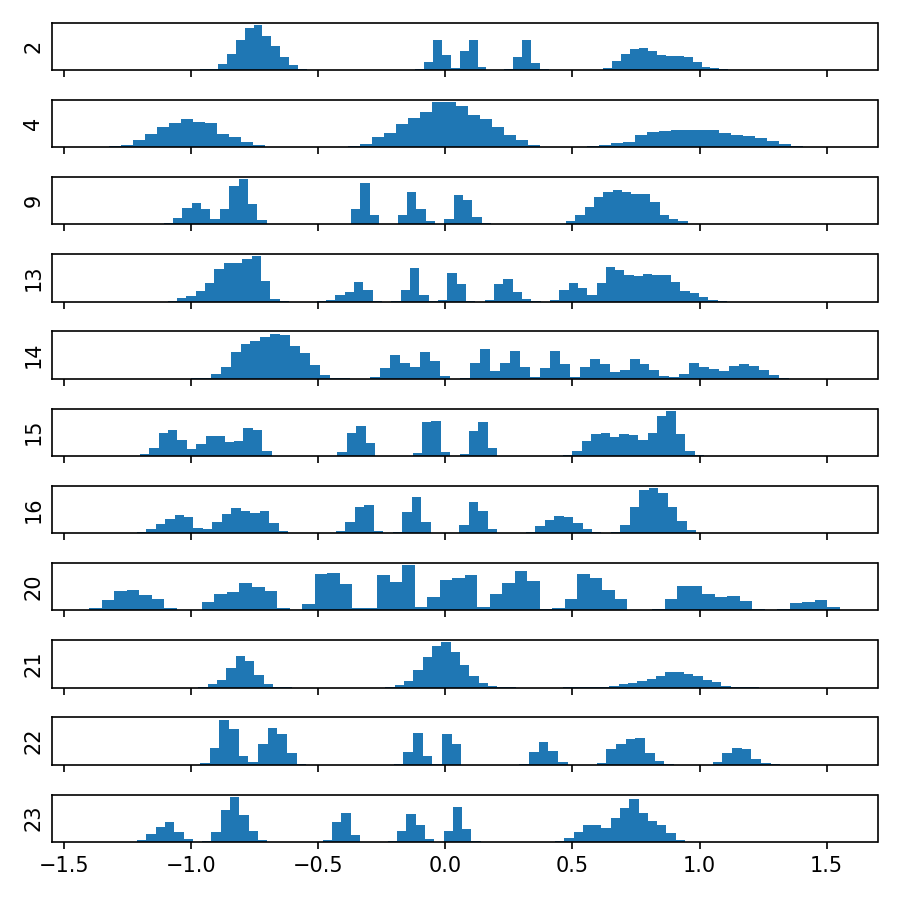

Figure latent_hists saved as {'png'}


In [306]:
pts = fullQ.cpu().t()[sel]
fg, axs = util.plot_hists(pts, bins=60, sharex=True);
for ax, s in zip(axs, sel.tolist()):
    plt.sca(ax)
    plt.ylabel(str(s))
#     plt.xticks([])
    plt.yticks([])
plt.tight_layout()
util.save_figure(f'latent_hists', root=figure_dir);

In [45]:

factor_dim = 4

ix, iy = 3, 4
ix, iy = 4, 6
ix, iy = 0, 6

ix, iy = None, None
# ix, iy = 4, 21

In [343]:
bidx = 0
q = Q[bidx]

In [344]:
if ix is not None and iy is not None:
    n = 12
    h, w = n, n

    mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
    mn, mx = mn.view(-1), mx.view(-1)

    cx, cy = torch.meshgrid(torch.linspace(mn[ix],mx[ix],h), torch.linspace(mn[iy],mx[iy],h))
    cx = cx.reshape(-1)
    cy = cy.reshape(-1)

    vecs = q.expand(len(cx), q.size(0)).contiguous()
    vecs[:, ix] = cx
    vecs[:, iy] = cy

    with torch.no_grad():
        x = model.decode(vecs.to(device))
    # x = x.view(h,w,*x.shape[1:])
        r,qr = model(x, ret_q=True)
        if isinstance(qr, distrib.Distribution):
            qr = qr.loc
    x = x.contiguous().cpu()
    r = r.contiguous().cpu()
    vecs = vecs.cpu()
    qr = qr.cpu()
    latent_losses = F.mse_loss(vecs,qr, reduction='none').view(x.shape[0],-1).mean(-1).view(h,w)
    img_losses = F.mse_loss(x,r, reduction='none').view(x.shape[0],-1).mean(-1).view(h,w)
    
    C, H, W = x.shape[-3:]
    x = x.cpu().numpy().reshape(h,w,C,H,W).transpose(1,0,2,3,4)[::-1].reshape(h*w,C,H,W)
    r = r.cpu().numpy().reshape(h,w,C,H,W).transpose(1,0,2,3,4)[::-1].reshape(h*w,C,H,W)
    #.reshape(h,w,*x.shape[1:]).permute(1,0,2,3,4).reshape(-1,*x.shape[1:]).cpu().numpy()
#     r = r.reshape(h,w,*x.shape[1:]).permute(1,0,2,3,4).reshape(-1,*x.shape[1:]).cpu().numpy()
    
    util.plot_imgs(x,H=h,W=w);
    util.save_figure(f'2D_traversal_{ix}_{iy}', root=figure_dir);
    
    util.plot_imgs(r,H=h,W=w);
    util.save_figure(f'2D_traversal_recovery_{ix}_{iy}', root=figure_dir);
    
    util.plot_mat(latent_losses.t().cpu().numpy()[::-1], val_fmt=1, figsize=(5,5));
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    util.save_figure(f'2D_traversal_latent_error_{ix}_{iy}', root=figure_dir);
    
    util.plot_mat(img_losses.t().cpu().numpy()[::-1], figsize=(5,5));
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    util.save_figure(f'2D_traversal_image_error_{ix}_{iy}', root=figure_dir);
    
    start, end = vecs.cpu().t()[[ix,iy]], qr.cpu().t()[[ix,iy]]

    plt.figure()
    plt.scatter(*start)
    delta = end - start
    # sel = slice(0,-1)
    plt.quiver(*start, *delta,angles='xy', scale_units='xy', scale=1, lw=0.5, alpha=0.5)
    plt.scatter(*end)
    plt.xlabel(f'Dimension {ix}')
    plt.ylabel(f'Dimension {iy}')
    
#     inv_imgs = torch.stack([sampler.full_intervention(factor_dim) for _ in range(10)])
#     B, N, C, H, W = inv_imgs.shape
#     with torch.no_grad():
#         int_q = model.encode(inv_imgs.to(device).view(B*N,C,H,W))
#         if isinstance(int_q, distrib.Distribution):
#             int_q = int_q.loc
#         int_q = int_q.view(B, N, -1).cpu()
#     plt.plot(*int_q[...,[ix,iy]].permute(2,1,0), c='r', ls='--', lw=0.5);
#     plt.tight_layout()
#     util.save_figure(f'2D_traversal_projection_factor{factor_dim}_{ix}_{iy}', root=figure_dir);

In [1163]:
n = 20
h, w = n, n

bidx = 0
q = Q[bidx]

# mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
# mn, mx = mn.view(-1), mx.view(-1)

# ix, iy = 3, 4
# ix, iy = 6, 7
# ix, iy = 10, 14
# ix, iy = 2, 9
ix, iy = 13, 14
# ix, iy = 4, 21

pdim = [ix, iy]
idim = [s for s in sel.tolist() if s not in pdim]
bgdim = bsel.tolist()
pdim, idim, bgdim

([13, 14],
 [2, 4, 9, 15, 16, 20, 21, 22, 23],
 [0, 1, 3, 5, 6, 7, 8, 10, 11, 12, 17, 18, 19])

In [1164]:
cx, cy = torch.meshgrid(torch.linspace(mn[ix],mx[ix],h), torch.linspace(mn[iy],mx[iy],h))
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = q.expand(len(cx), q.size(0)).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy

In [1165]:
seqs = [vecs]

In [1166]:
for i in range(8):
    current = seqs[-1]
    with torch.no_grad():
        current = model.encode(model.decode(current.to(device)))
        if isinstance(current, distrib.Distribution):
            current = current.loc
    seqs.append(current.cpu())
len(seqs), seqs[0].shape

(9, torch.Size([400, 24]))

In [1167]:
fullpts = torch.stack(seqs).div(scales.cpu().view(1,1,-1)).cpu()
pts = fullpts[...,pdim]
ots = fullpts[...,idim]
bts = fullpts[...,bgdim]
dists = pts[1:].sub(pts[:-1]).pow(2).sum(-1).sqrt().cpu()
pts.shape, bts.shape, dists.shape

(torch.Size([9, 400, 2]), torch.Size([9, 400, 13]), torch.Size([8, 400]))

In [1168]:
# plt.figure()
# for ds, c in zip(dists.t(), [('C1' if c else 'C0') for c in dists[0].gt(0.5)]):
#     plt.plot(ds, color=c);#.t());

<IPython.core.display.Javascript object>


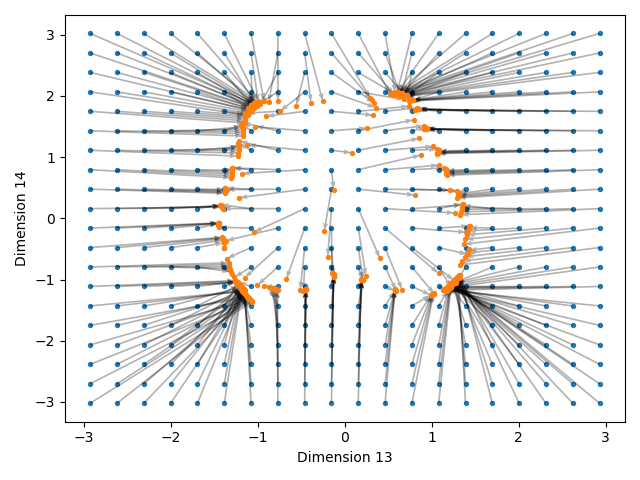

In [1170]:
plt.figure()
start = None
for p2 in pts[:2]:
    end = p2.t()
    if start is not None:
        delta = end - start
        plt.quiver(*start, *delta, angles='xy', scale_units='xy', scale=1, lw=0.2, alpha=0.3)
    plt.scatter(*end, s=8)
    start = end
    pass

plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.xlim(pts[...,0].min()*1.1, pts[...,0].max()*1.1)
plt.ylim(pts[...,1].min()*1.1, pts[...,1].max()*1.1)
plt.tight_layout();
util.save_figure(f'proj_{len(pts)-1}_{ix}_{iy}', root=figure_dir);

In [152]:
bgdim

[0, 5]

In [153]:
berr = bts[1:].sub(bts[:-1]).abs().max(-1)[0]
ierr = ots[1:].sub(ots[:-1]).abs().max(-1)[0]
perr = pts[1:].sub(pts[:-1]).abs().max(-1)[0]
perr.shape, ierr.shape, berr.shape

(torch.Size([8, 400]), torch.Size([8, 400]), torch.Size([8, 400]))

In [154]:
# p = perr[1:].sub(perr[:-1]).max(-1)[0]
# b = berr[1:].sub(berr[:-1]).max(-1)[0]
# ie = ierr[1:].sub(ierr[:-1]).max(-1)[0]
# p = perr[1:].sub(perr[:-1])#.mean(-1)
# # b = berr[1:].sub(berr[:-1])#.mean(-1)

p = perr.mean(-1)
b = berr.mean(-1)
ie = ierr.mean(-1)
p = perr.max(-1)[0]
b = berr.max(-1)[0]
ie = ierr.max(-1)[0]

In [155]:
ie, p, b

(tensor([2.3782e-01, 1.9709e-01, 7.1046e-02, 4.6383e-02, 5.5419e-03, 8.7523e-04,
         1.1015e-04, 9.1791e-06]),
 tensor([2.9608e+00, 9.3429e-01, 2.5729e-01, 1.8168e-01, 1.0223e-01, 1.2360e-02,
         7.5674e-04, 4.1127e-05]),
 tensor([1.6034e+00, 1.7401e+00, 2.6088e-01, 2.7267e-01, 1.4863e-01, 1.6928e-02,
         1.0423e-03, 6.3300e-05]))

<IPython.core.display.Javascript object>


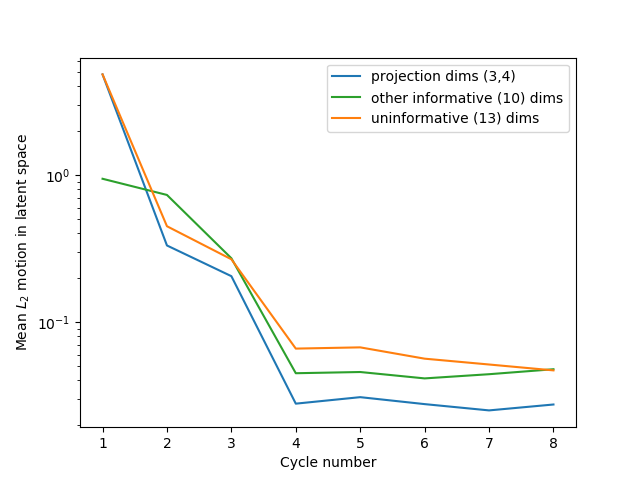

In [58]:
plt.figure()

num = np.arange(len(p))+1

plt.plot(num,p, c='C0', label=f'projection dims ({ix},{iy})');
plt.plot(num,ie, c='C2', label=f'other informative ({len(idim)}) dims');
plt.plot(num,b, c='C1', label=f'uninformative ({len(bgdim)}) dims');
plt.yscale('log');
plt.legend();
plt.xlabel('Cycle number')
plt.ylabel('Mean $L_2$ motion in latent space');
util.save_figure(f'latent_motion_{ix}_{iy}', root=figure_dir);

In [156]:
factor_types = ['per', 'per', 'per', 'seq', 'cat', 'seq']
factors

['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']

In [157]:
# ind = torch.tril_indices(N,N,-1)
# iq[:,ind].shape
# ind.shape

In [48]:
N = 10

In [58]:
qq = torch.arange(N).unsqueeze(-1)/N#*2*np.pi
qq = qq[torch.tril_indices(N,N,-1)]

In [66]:
#[:20]

tensor([0.1000, 0.2000, 0.1000, 0.3000, 0.2000, 0.1000, 0.4000, 0.3000, 0.2000,
        0.1000, 0.5000, 0.4000, 0.3000, 0.2000, 0.1000, 0.4000, 0.5000, 0.4000,
        0.3000, 0.2000, 0.1000, 0.3000, 0.4000, 0.5000, 0.4000, 0.3000, 0.2000,
        0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.4000, 0.3000, 0.2000, 0.1000,
        0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.4000, 0.3000, 0.2000, 0.1000])

In [707]:
# qq[...,:20,0].t()

In [ ]:

# qa = torch.cat([qq.mul(2*np.pi).sin(), qq.mul(2*np.pi).cos()], -1)
qa = 
pD = qa[1].sub(qa[0]).pow(2).sum(-1).sqrt()

In [1141]:
def theta_dists(N):
    qq = torch.arange(N).unsqueeze(-1)/N#*2*np.pi
    qq = qq[torch.tril_indices(N,N,-1)]
    return util.angle_diff(qq[1],qq[0],period=1.).abs().squeeze()
def per_dists(N):
    qq = torch.arange(N).unsqueeze(-1)/N
    qq = qq[torch.tril_indices(N,N,-1)]
    qa = torch.cat([qq.mul(2*np.pi).sin(), qq.mul(2*np.pi).cos()], -1)
    pD = qa[1].sub(qa[0]).pow(2).sum(-1).sqrt()
    return pD
def seq_dists(N):
    qq = torch.arange(N).unsqueeze(-1)/N
    qq = qq[torch.tril_indices(N,N,-1)]
    lD = qq[0].sub(qq[1]).pow(2).sum(-1).sqrt()
    return lD
def cat_dists(N):
    N = N*(N-1)//2
    return torch.ones(N).float()
dist_fns = {'cat':cat_dists, 'seq':seq_dists, 'per':theta_dists, 'per-2d':per_dists}
d_order = ['cat','seq','per','per-2d']
d_order = ['cat','seq','per']

def dist_mat(N):
    return torch.stack([cat_dists(N), seq_dists(N), theta_dists(N)], -1)
    return torch.stack([cat_dists(N), seq_dists(N), theta_dists(N), per_dists(N)], -1)


In [1142]:
rq = []
for idx, (name, invs) in enumerate(zip(factors, interventions)):
    
    B,N,C,H,W = invs.shape
#     true = dist_fns[typ](N)
    true = dist_mat(N)
    true /= true.norm(dim=0,keepdim=True)
    
    with torch.no_grad():
        iq = model.encode(invs.view(B*N,C,H,W))
        if isinstance(iq, distrib.Normal):
            iq = iq.loc
        iq = iq.view(B,N,D).cpu()
    
    i,j = torch.tril_indices(N,N,-1)
    pred = iq[:,i].sub(iq[:,j]).pow(2).sum(-1)
    pred /= pred.norm(dim=-1, keepdim=True)
    
    rq.append(pred @ true)
    
#     break
rq = torch.stack(rq)
rq.shape

torch.Size([6, 20, 3])

<IPython.core.display.Javascript object>


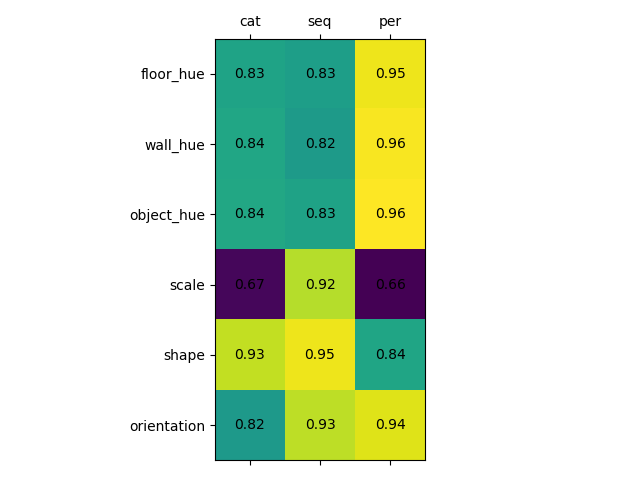

In [1143]:
util.plot_mat(rq.mean(1), val_fmt=2);
plt.yticks(range(len(factors)), factors)
plt.xticks(range(len(d_order)), d_order);
plt.tight_layout()
util.save_figure(f'repr_quality', root=figure_dir);

In [196]:
# run.update_results('repr_quality', rq.mean(1).detach().cpu())

tensor([[0.6239, 0.8568, 0.6415],
        [0.6501, 0.9134, 0.6609],
        [0.6566, 0.9194, 0.6717],
        [0.6909, 0.9476, 0.7172],
        [0.7565, 0.9450, 0.7616],
        [0.6429, 0.9205, 0.6643]])

In [197]:
# run.get_results('repr_quality')

tensor([[0.6239, 0.8568, 0.6415],
        [0.6501, 0.9134, 0.6609],
        [0.6566, 0.9194, 0.6717],
        [0.6909, 0.9476, 0.7172],
        [0.7565, 0.9450, 0.7616],
        [0.6429, 0.9205, 0.6643]])

In [171]:
from torch.autograd import grad

In [172]:
bidx = 1
q = Q[bidx].clone()
q = Q.clone()

In [174]:
for param in model.parameters():
    param.requires_grad = False
q.requires_grad = True

In [175]:
# bq = q.unsqueeze(0).expand(12, -1)
# bq.shape

In [176]:
xh, qh = ae_cycle(q)
xh.shape, qh.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 12]))

In [177]:
gs = []
for i in range(12):
    obj = qh[:,i].sum(0)
    gr = grad(obj, q, retain_graph=True, only_inputs=True)[0]
    gs.append(gr)
gd = torch.stack(gs)
gd.shape

torch.Size([12, 64, 12])

In [178]:
obj = F.mse_loss(q.to(device),qh.to(device), reduction='none').sum(0)
gs = []
for o in obj:
    gr = grad(o, q, retain_graph=True, only_inputs=True)[0]
    gs.append(gr)
gl = torch.stack(gs)
gl.shape
# gl = grad(obj, q.to(device), retain_graph=True, only_inputs=True)[0]
# gl.shape

torch.Size([12, 64, 12])

In [179]:
g = gd.abs().mean(1)
# g = gd[:,np.random.randint(g.size(1))]

# g = gl.mean(1)

g = g.abs()

<IPython.core.display.Javascript object>


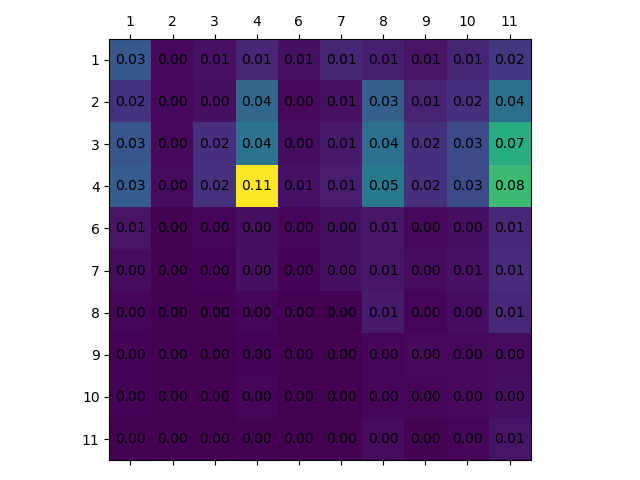

In [180]:
util.plot_mat(g[sel][:,sel], val_fmt=2);
# plt.ylabel('Intervention')
# plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
util.save_figure(f'jacobian-sel', root=figure_dir)
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)

<IPython.core.display.Javascript object>


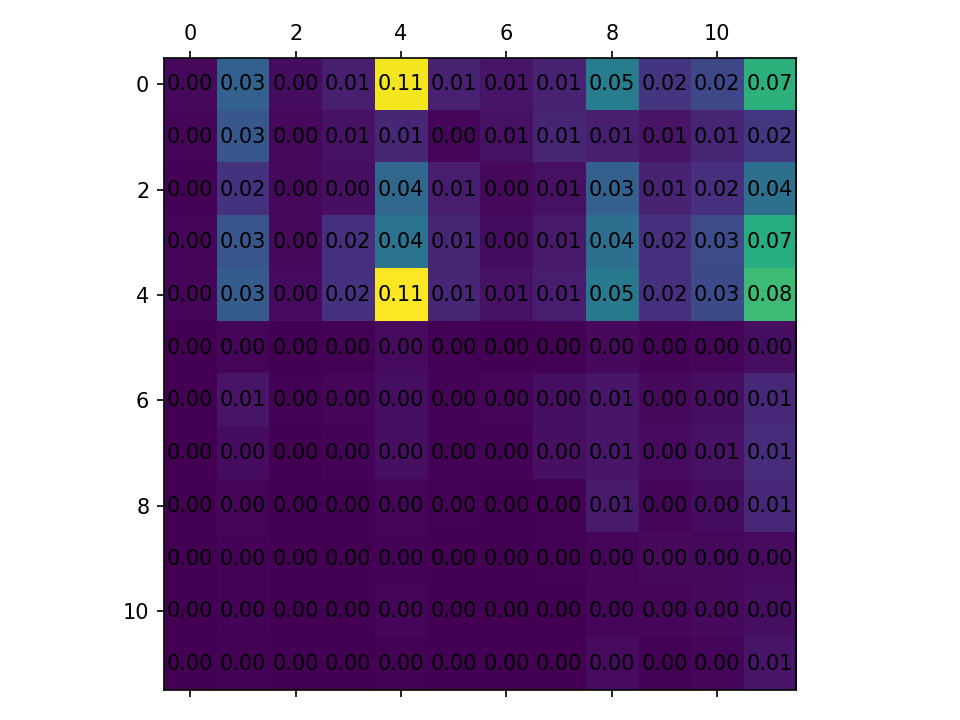

In [69]:
util.plot_mat(g, val_fmt=2);
plt.tight_layout();
util.save_figure(f'jacobians', root=figure_dir)

In [56]:
gd.shape

torch.Size([12, 64, 12])

In [57]:
# start = q[...,[ix,iy]].cpu().detach().t()
# delta = gd[[ix,iy]][...,[ix,iy]].diagonal(dim1=0,dim2=-1).cpu().detach().t().mul(1)

# plt.figure()
# plt.scatter(*start)
# # sel = slice(0,-1)
# plt.quiver(*start, *delta,angles='xy', scale_units='xy', scale=1, lw=0.5, alpha=0.5)
# # plt.scatter(*end)
# plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.tight_layout()
# # util.save_figure(f'2D_traversal_projection_factor{factor_dim}_{ix}_{iy}', root=figure_dir);

In [181]:
steps = 20

stretch = 0.1
mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
mn, mx = mn.view(-1), mx.view(-1)

In [182]:
bidx = 1
q = Q[bidx].clone()

In [183]:
ix, iy = 0, 4
# ix, iy = 6, 7
# ix, iy = 8, 11
# ix, iy = 9, 10
# ix, iy = 1, 9

In [184]:
cx, cy = torch.meshgrid(torch.linspace(mn[ix],mx[ix],steps), torch.linspace(mn[iy],mx[iy],steps))
cx = cx.reshape(-1)
cy = cy.reshape(-1)

vecs = q.expand(len(cx), q.size(0)).contiguous()
vecs[:, ix] = cx
vecs[:, iy] = cy
vecs.shape

torch.Size([400, 12])

In [185]:
def ae_cycle(q):
    im = model.decode(q.to(device))
    q = model.encode(im)
    return im.cpu(), q.cpu()

In [186]:
with torch.no_grad():
    oq = ae_cycle(vecs)[1]
    
q1, q2 = vecs.cpu().clone().div(scales.cpu().unsqueeze(0)), oq.cpu().clone().div(scales.cpu().unsqueeze(0))
q1.shape, q2.shape

(torch.Size([400, 12]), torch.Size([400, 12]))

In [187]:
dl = q2 - q1
dl.shape

torch.Size([400, 12])

In [188]:
mags = dl.abs()[...,[ix,iy]].sum(-1).view(steps,steps)
# mags = mags.clamp(max=1)
mags.shape

torch.Size([20, 20])

<IPython.core.display.Javascript object>


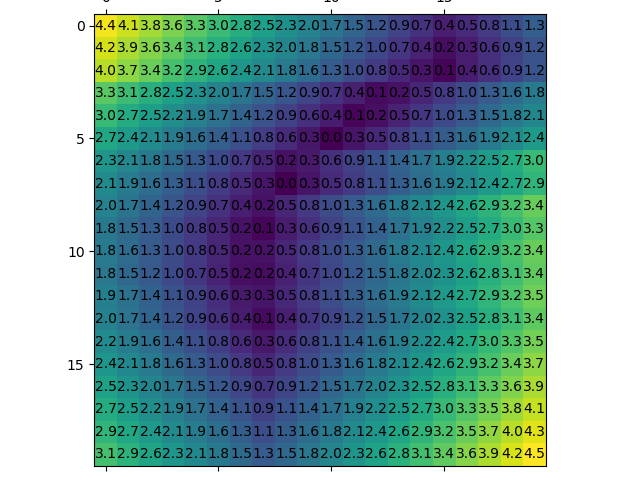

<IPython.core.display.Javascript object>


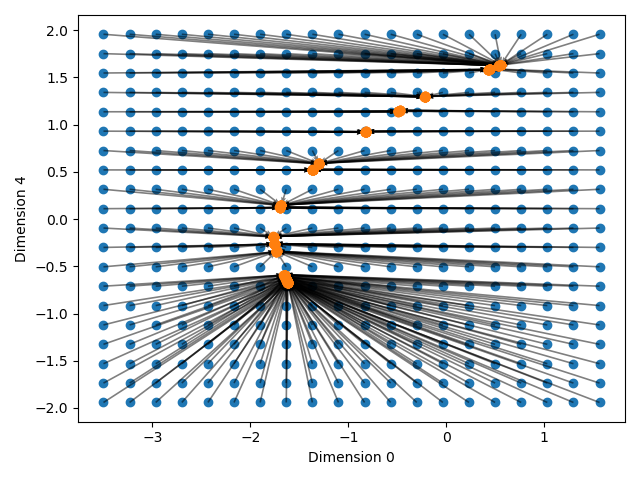

In [189]:
# plt.figure()
# plt.imshow(mags)
util.plot_mat(mags.t().numpy()[::-1], val_fmt=1);

start, end = q1.cpu().t()[[ix,iy]], q2.cpu().t()[[ix,iy]]

plt.figure()
plt.scatter(*start)
delta = end - start
# sel = slice(0,-1)
plt.quiver(*start, *delta,angles='xy', scale_units='xy', scale=1, lw=0.5, alpha=0.5)
plt.scatter(*end)
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')

plt.tight_layout();
# util.save_figure(f'2D_traversal_projection_factor{factor_dim}_{ix}_{iy}', root=figure_dir);